## 8. МАШИННОЕ ОБУЧЕНИЕ В АНАЛИЗЕ ВРЕМЕННЫХ РЯДОВ
Рассмотрим несколько примеров применения методов машинного обучения к анализу временных рядов. Это относительно новая дисциплина науки о данных, но она демонстрирует многообещающие результаты. В отличие от статистических моделей, которые мы изучали ранее, методы машинного обучения, с которыми нам предстоит познакомиться, изначально не разрабатывались для анализа временных рядов, но оказались очень полезными для работы с ними.
Переход к технологиям машинного обучения задуман как продолжение изысканий по составлению прогнозов, проводимых ранее. До настоящего момента наше внимание было сконцентрировано на статистических моделях прогнозирования временных рядов. При разработке таких моделей мы сформулировали основную теорию описания динамики временного ряда и статистических способов представления шума и неопределенности в его поведении. Впоследствии на основе рассчитанной гипотетической динамики процесса были составлены прогнозы и оценена степень их неопределенности. При таком подходе идентификация и оценка параметров модели требовали предельно тщательной проработки — они должны наилучшим образом описывать динамику изменения данных.
Здесь рассматриваются вычислительные методики, в которых не учитываются характеристики базового процесса и правила, описывающие его поведение. Вместо этого в них поведение системы описывается согласно шаблонам, которые распознаются с помощью методов, сходных с применяемыми для предсказания целевой величины, например, классификационных подписей в данных временного ряда. В ней мы также рассмотрим методы обучения без учителя на примере кластеризованных данных временных рядов.
Здесь для описания принципов прогнозирования и классификации применяются древовидные модели, а кластеризация представлена как специальная форма классификации. В методах классификации деревьев крайне важно определиться с признаками временного ряда, поскольку в них, в отличие, например, от ARIMA, не учитываются временные изменения в поведении данных.
В случае кластеризации и метрической классификации будет показано, что в качестве входных данных можно использовать как признаки, так и исходные временные ряды. Чтобы подать на вход сам временной ряд, нужно рассчитать метрику расстояния, известную как динамическая трансформация времени, которая в случае применения к временным рядам позволяет сохранить в данных полный хронологический набор информации, не прибегая к ее представлению ограниченным набором признаков.


In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [30]:
import cesium 
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

import scipy
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [31]:
print(cesium.__version__)
print(xgb.__version__)
print(scipy.__version__)
print(sklearn.__version__)

0.12.3
2.0.3
1.14.1
1.2.2


## Классификация временных рядов
Рассматривается пример представления признаками необработанных временных рядов данных электроэнцефалограммы (ЭЭГ), которые в дальнейшем подвергаются обработке с помощью алгоритмов машинного обучения.


Ранее мы посвятили много времени, описывая цели, преследуемые при генерации признаков временных рядов. Кроме того, рассматривался небольшой пример получения признаков для данных временных рядов с помощью пакета tsfresh. В этой части признаки для временных рядов будут генерироваться с помощью другого, также обсуждаемого ранее, программного пакета cesium.
Одно из главных преимуществ пакета cesium заключается в его снабжении множеством полезных наборов временных рядов, включая данные ЭЭГ, первоначально полученных в исследовательской работе 2001 года. В ней детально описаны все операции по подготовке данных. Нам же достаточно знать, что все пять категорий временных рядов ЭЭГ из встроенного набора данных представляют собой фрагменты равной длины, вырезанные из непрерывных временных отсчетов, избранных ЭЭГ. В частности, среди них вы найдете следующие временные ряды.
• ЭЭГ-записи здоровых людей с открытыми и закрытыми глазами (две отдельные категории)
• ЭЭГ-записи пациентов с эпилепсией в периоды без судорог для двух областей мозга, не связанных с проявлением судорог (две отдельные категории)
• Внутричерепная запись ЭЭГ во время судорог (одна категория) Набор данных загружается с помощью специальной функции, также включенной в пакет cesium.


In [32]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()


Всегда полезно предварительно просмотреть несколько примеров анализируемых данных, чтобы получить представление о том, как такие временные ряды лучше всего классифицировать.

На графиках заметны отчетливые различия между классами ЭЭГ (рис. 8.1). И это не удивительно: графики ЭЭГ указывают на активность разных частей мозга при выполнении разных действий — как у здоровых субъектов, так и у пациентов с эпилепсией. Результат визуализации может послужить руководством к генерации признаков

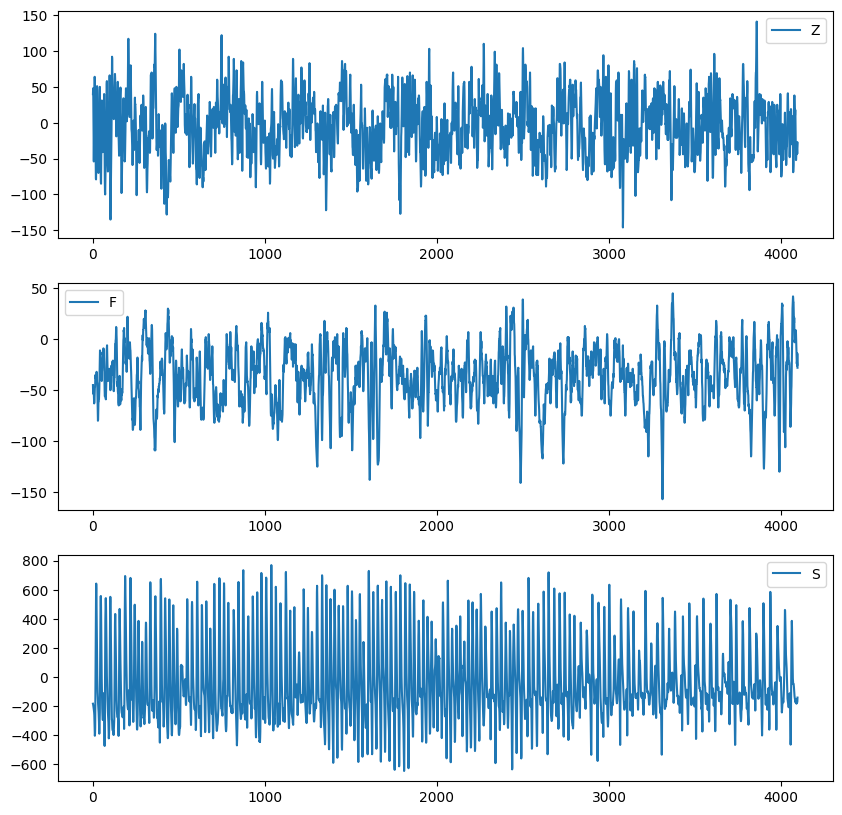

In [33]:
plt.subplot(3, 1, 1)
plt.plot(eeg[ "measurements"][0])
plt.legend(eeg['classes' ][0])
##Z
plt.subplot(3, 1, 2)
plt.plot (eeg['measurements'][300])
plt.legend(eeg['classes' ][300] )
##F
plt.subplot (3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes' ][450])
##S


В частности, классы Z и F, скорее всего, содержат меньше искаженных данных, чем класс S. Кроме того, как видно по оси у, каждый класс характеризуется своим, отличным от остальных, диапазоном значений. Это указывает на то, что в качестве признака может использоваться амплитуда. Помимо того, графики различаются не только амплитудой значений, но и общим распределением точек, которые различаются у всех трех классов. Таким образом, в дальнейшем анализе мы будем опираться на эти и некоторые другие признаки, после чего напишем код их генерации.

### Визуализация и машинное обучение
Данные ЭЭГ отлично визуализируются на двумерной гистограмме. В частности, такая гистограмма предельно точно представляет данные каждого типа временных рядов и подтверждает (или опровергает) репрезентативность исследуемых признаков. В нашем случае она позволяет установить, будет ли амплитуда или наклон прямой устойчиво различаться для разных классов.
Кроме того, нелишне построить одномерные гистограммы — по одной на класс. Также рассмотрите возможность проведения дополнительных исследований, заключающихся в ядерной оценке плотности (ru.wikipedia.org/wiki/Ядерная_оценка_плотности) для каждого класса.
Визуально ядерная оценка плотности схожа с гистограммой, но строится так, чтобы обладать специальными свойствами, такими как непрерывность и гладкость, эффективно приводя необработанные данные гистограммы к плавному, непараметрическому оценочному распределению для базовой переменной. Википедия предлагает хорошее описание ядерной оценки плотности, которая может быть выполнена с помощью таких программных инструментов, как пакет scikit-learn в языке Python или функция density() пакета stats в языке R.


## Сгенерируем признаки с помощью пакета cesium.

In [34]:
from cesium.featurize import featurize_time_series as ft
features_to_use = ["amplitude","percent_close_to_median","skew","max_slope"]
fset_cesium = ft(times = eeg["times"],values = eeg["measurements"],errors = None,features_to_use = features_to_use,scheduler = None)


Проверка сгенерированного признака.
Заметьте, что многие значения не нормализованы. Это следует учитывать при использовании методов, которые требуют передачи исключительно нормализованных входных данных.
Нужно четко понимать, на что именно указывают признаки, и уметь сопоставлять ожидания с результатами, полученными с помощью пакета cesium.
Чтобы проиллюстрировать важность проверки полученных результатов и отсутствия противоречий со здравым смыслом, давайте проанализируем параметр percent_beyond_1_std для единственной выборки временного ряда.


In [35]:
np.std(eeg["measurements"][0])


40.41100040099819

In [36]:
np.mean(eeg["measurements"][0])

-4.1320478398828415

In [37]:
sample_ts = eeg["measurements"][0]
sz = len(sample_ts)
ll = -4.13 - 40.4
ul = -4.13 + 40.4
quals = [i for i in range(sz) if sample_ts[i] < ll or sample_ts[i] > ul]
len(quals)/sz

0.3273126678057115

In [38]:
fset_cesium = pd.read_csv("/kaggle/input/dataset-ex8/full_eeg_data_features.csv", header = [0, 1])

In [39]:
fset_cesium.head()

,feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
,channel,0,0,0,0,0
0,0,143.5,0.327313,0.505004,0.032805,11107.796610
1,1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,3,171.5,0.300952,0.541128,0.063678,17008.813559
4,4,170.0,0.305101,0.566268,0.142753,13016.949153


In [40]:
fset_cesium.shape

(500, 6)

### Эргодические признаки
При выборе признаков временного ряда из автоматически сгенерированных вариантов обращайте внимание только на эргодические признаки. Они предполагают, что каждое из измерений будет сходиться к устойчивому значению по мере сбора большего на графике, различные подвыборки из любого заданного временного ряда явно сопоставимы, а сам ряд слабо стационарен, поэтому сгенерированные признаки имеют смысл.
Необходимо иметь возможность проверки используемых признаков. Это вопрос ответственного анализа. Не стоит предоставлять алгоритму информацию, которую нельзя понять, объяснить и проверить.
Не злоупотребляйте библиотеками, предназначенными для генерации признаков. Написать собственный код генерации признаков совсем не трудно. Если вы работаете с данными предметной области, в которой определенный набор признаков используется неоднократно и в одних и тех же комбинациях, то постарайтесь написать собственный код реализации алгоритма (даже если исходно использовали инструменты программных библиотек).
Вы сможете оптимизировать собственное решение намного лучше, чем разработчики равнозначного универсального пакета. Например, располагая несколькими признаками, основанными на вычислении среднего значения временного ряда, можно создать код однократного вычисления такого значения и не дублировать его для каждого отдельно рассчитываемого признака.


### Деревья принятия решений
Деревья принятия решений имитируют принятые у людей способы принятия решений — пошагово и в высшей степени нелинейно. Они отражают принципы принятия нами сложных решений: одно за раз, изучая то, как текущая переменная влияет на полученное решение, затем учитывается следующий вариант — очень похоже на блок-схему.
С большой вероятностью вам уже доводилось работать с деревьями принятия решений или вы знакомы с их общей концепцией. Если это не так, то поставьте изучение материала на паузу, сделайте перерыв и ознакомьтесь с основными справочными сведениями о деревьях принятия решений (https://perma.сс/G9AA-ANEN).
Существует множество примеров человеческого поведения, следующего принципам дерева принятия решений при анализе данных временных рядов. Например, независимые трейдеры на фондовом рынке также получают доступ к техническим индикаторам, но, скорее всего, изучают их пошагово в некой иерархически выверенной манере, подобно тому, как это принято в дереве нелинейных решений — сначала определяя направление движения рынка по одному техническому индикатору, а затем, получив один из вариантов ответа, исследуя для него временные изменения волатильности. По всей видимости, они удерживают в памяти некое подобие древовидной структуры принятия решений, которую они используют, чтобы составлять достаточно точные прогнозы о направлении движения рынка.
Подобным образом медицинские сотрудники читают ЭЭГ и ЭКГ. Сначала они ищут хотя бы один из известных признаков, и только затем переходят к поиску следующего, последовательно учитывая все возможные факторы. При наличии только одного признака и отсутствии другого диагноз будет отличаться от утверждаемого в противном случае и, следовательно, другого прогноза относительно состояния пациента.
Далее рассмотрим признаки, сгенерированные для данных ЭЭГ, применяемых в качестве входных данных в двух разных методах дерева принятия решений — случайного леса и градиентного бустинга деревьев, — каждый из которых используется в задачах классификации. Наша задача будет заключаться в классификации исследуемых данных ЭЭГ исключительно на основе признаков, сгенерированных из необработанных данных.


In [41]:
ex = eeg["measurements"][0]

In [42]:
ex_mean = np.mean(ex)
ex_std  = np.std(ex)

In [43]:
# amplitude
(np.max(ex) - np.min(ex)) / 2

143.5

In [44]:
 
siz = len(ex)
ll = ex_mean - ex_std
ul = ex_mean + ex_std

quals = [i for i in range(siz) if ex[i] < ll or ex[i] > ul]
len(quals)/len(ex)

0.3273126678057115

In [45]:
# percent_close_to_median
# Percentage of values within window_frac*(max(x)-min(x)) of median.
# find the source code here:
# https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
# window frac = 0.1
window = 0.1 * (np.max(ex) - np.min(ex))
np.where(np.abs(ex_mean - ex) < window)[0].shape[0] / ex.shape[0]

0.5050036612155235

0.03280499636078603


(array([  10.,   57.,  276.,  730., 1048., 1042.,  621.,  263.,   42.,
           8.]),
 array([-146. , -117.3,  -88.6,  -59.9,  -31.2,   -2.5,   26.2,   54.9,
          83.6,  112.3,  141. ]),
 <BarContainer object of 10 artists>)

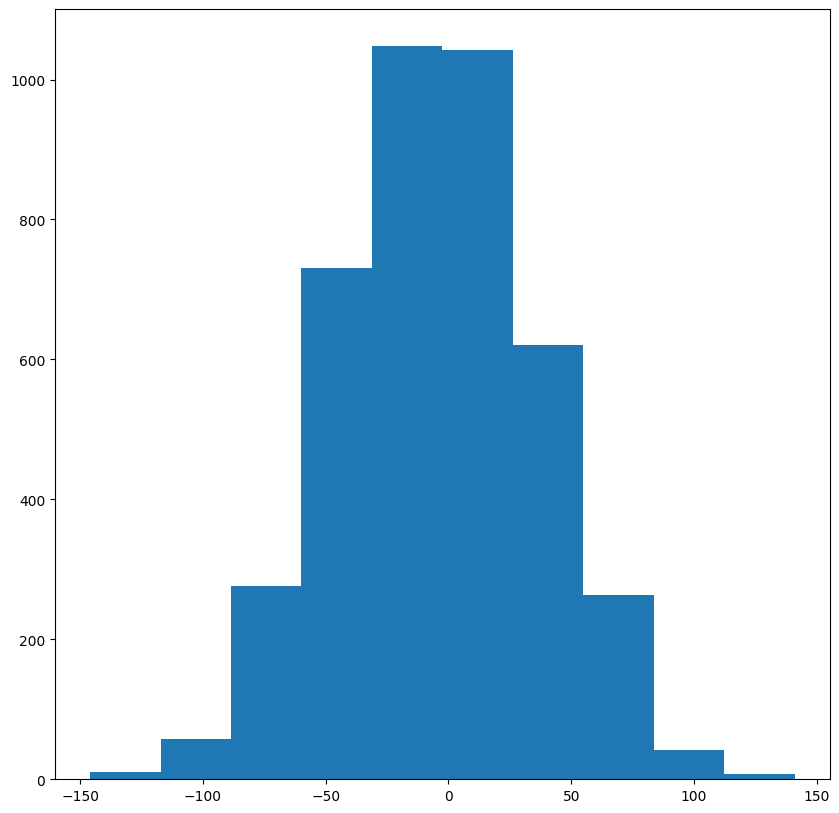

In [46]:
## skew
print(skew(ex))
plt.hist(ex)

In [47]:
## max slope
## again check definition : https://github.com/cesium-ml/cesium/blob/master/cesium/features/common_functions.py
times = eeg["times"][0]
np.max(np.abs(np.diff(ex)/np.diff(times)))

11107.796610166752

## Подготовка выборки

In [48]:
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values,
      eeg["classes"], train_size=0.67, random_state=21)

### Случайный лес
Случайный лес — это модель, в которой используется не одно, а множество деревьев принятия решений. Результатом усреднения выходных данных таких деревьев будет классификация или регрессия данных. Случайные леса основаны на понятии “мудрости толпы”, где “толпа” представлена большим количеством простых моделей, ни одна из которых сама по себе не может быть достаточно хороша, но все вместе они часто превосходят даже самое точное, но единственное дерево решений.
Идея собрать коллекцию моделей для составления точного прогноза, а не просто найти единственную “лучшую” модель, была высказана еще в 1969 году в статье Combination of Forecasts (Комбинации прогнозов) — исследовательской работе двух именитых статистов, Дж. М. Бейтса и С. В. Дж. Грейнджер. В этом документе показано, что объединение двух отдельных прогнозов данных о пассажирах авиакомпании может привести к получению модели с более низкой среднеквадратичной ошибкой, что оказывается совершенно неожиданным и в то же время неубедительным результатом. Тем не менее молодое поколение аналитиков, часто прибегающих при исследовании данных к услугам алгоритмов машинного обучения (в противоположность статистическим методам), наоборот, считают такой подход интуитивно понятным, а не обескураживающим. Очень быстро случайный лес деревьев стал наиболее частым решением, применяемым к большинству задач прогнозирования.
Случайный лес строится в соответствии с параметрами, определяющими количество деревьев для обучения, а также максимально допустимую глубину этих деревьев. Впоследствии обучение каждого отдельного дерева выполняется на случайной выборке данных и их признаков. Деревья, как правило, параметризуются так, чтобы получить максимально простую структуру и избежать эффекта переобучения, а модель должна уметь усреднять многие другие модели, ни одна из которых не является особенно хорошей, но все они достаточно общие, чтобы избежать “ловушек”, таящихся в данных. Как упоминалось ранее, признаки, рассчитанные для каждой выборки временного ряда, вводятся в модель в качестве результатов обучения. Теоретически можно придумать способы ввода в модель не вычисленных признаков, а необработанных временных рядов, но их разработка связана с рядом трудностей.
• Временные ряды неодинаковой длины обрабатывать очень сложно.
• Использование большого количества входных данных (равного или близкого к числу временных шагов) приведет к созданию невероятно сложных и дорогостоящих для вычисления, а также обучения моделей.
• Если предположить, что ни один временной шаг не является важным (поскольку каждый временной шаг соответствует хотя бы одному признаку), то модель будет характеризоваться высоким уровнем шума и низким уровнем полезного сигнала для обучения, что будет проявляться на каждом шаге ввода данных.
Таким образом, случайные леса не являются хорошим инструментом для исследования данных временных рядов в необработанном виде, но становятся полезными после сжатия данных в сводные признаки. Перечислим несколько подтверждающих факторов.
• С точки зрения эффективности/вычислительных затрат принято считать, что очень длинные временные ряды всегда можно представить набором признаков и подобрать для них модель с разумной точностью.
• Очень важно добиться того, чтобы случайный лес понижал риск переобучения.
Как обсуждалось ранее, переобучение является особенно частой проблемой анализа временных рядов из-за наличия выраженной взаимосвязи между методами обучения и прогнозирования. Преднамеренно упрощенная методология позволяет устранить некоторые из потенциальных трудностей.
• Случайные леса могут быть особенно подходящими для данных временных рядов, для которых не предусмотрена рабочая модель или гипотеза о механике базового процесса.
Специалистам по анализу удалось добиться заметных успехов только в развертывании случайных лесов в задачах классификации временных рядов, но не в прогнозирования данных. В противоположность им рассматриваемый в следующем разделе метод, градиентный бустинг деревьев, получил широкое распространение при решении задач обоих типов.

### Градиентный бустинг деревьев

Бустинг является еще одним способом построения ансамбля предикторов. Бустинг, предполагающий последовательный способ построения модели, основан на предположении, что более поздние модели исправляют ошибки более ранних моделей, а несоответствие данных в более ранних моделях должно в большей степени учитываться и устраняться более поздними моделями.
Градиентный бустинг деревьев оказался особенно успешным методом исследования временных рядов, о чем свидетельствует его популярность среди участников соревнований по анализу данных, проводимых в течение нескольких последних лет.
Библиотека XGBoost строит деревья принятия решений последовательным образом так, что каждое следующее дерево стремится предсказать остатки комбинации предыдущих деревьев. Так, например, первое дерево, построенное библиотекой XGBoost, будет пытаться сопоставить данные напрямую (категория или числовое значение). Второе дерево будет предсказывать истинное значение за вычетом прогнозируемого значения. Третье дерево будет предсказывать истинное значение минус предсказанное значение первого дерева минус предсказание второго дерева об остатках первого дерева.
Однако библиотека XGBoost, пытаясь минимизировать остатки прогнозируемых остатков прогнозируемых остатков, и так до бесконечности, не стремится создать неисчислимое количество моделей. Алгоритм XGBoost минимизирует функцию потерь, которая также включает штрафной член для сложности модели, и именно этот штрафной член ограничивает количество получаемых деревьев.
Кроме того, количество производимых деревьев можно указать напрямую. За последние несколько лет появилось много извещений о больших успехах использования пакета XGBoost не только в методах машинного обучения, но и методах анализа временных рядов. В частности, они поступали с соревнований Kaggle и отраслевых конференций по машинному обучению.
Баггинг (или, более формально, бустстрэп-агрегирование) — это метод обучения моделей, при котором для каждой отдельной модели в ансамбле создаются случайно сгенерированные обучающие наборы. Случайные леса, как правило, используют методологию баггинга при обучении моделей.
Бустинг, как отмечалось выше, относится к методу обучения моделей, в которых ансамбль состоит из последовательно обучаемых моделей, каждая из которых направлена на исправление ошибки, допущенной ее предшественницей. Градиентный бустинг лежит в основе обучения деревьев.


## Try a random forest with these features

In [49]:
clf = RandomForestClassifier(n_estimators=10, max_depth=3,
                              random_state=21)

In [50]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [51]:
clf.score(X_train, y_train)

0.9432835820895522

In [52]:
clf.score(X_test, y_test)

0.9575757575757575

In [53]:
np.unique(y_test, return_counts=True)

(array(['F', 'N', 'O', 'S', 'Z'], dtype='<U1'), array([28, 36, 33, 31, 37]))

In [54]:
y_test

array(['O', 'S', 'N', 'F', 'S', 'S', 'Z', 'S', 'O', 'Z', 'F', 'O', 'S',
       'F', 'Z', 'N', 'Z', 'O', 'Z', 'Z', 'S', 'F', 'O', 'N', 'F', 'F',
       'Z', 'N', 'Z', 'N', 'S', 'Z', 'O', 'O', 'S', 'S', 'N', 'S', 'N',
       'S', 'N', 'O', 'N', 'S', 'Z', 'N', 'O', 'Z', 'Z', 'S', 'O', 'Z',
       'F', 'F', 'S', 'Z', 'N', 'O', 'N', 'F', 'Z', 'Z', 'N', 'Z', 'F',
       'Z', 'N', 'F', 'O', 'N', 'N', 'Z', 'N', 'O', 'N', 'F', 'O', 'F',
       'F', 'Z', 'S', 'N', 'Z', 'N', 'O', 'N', 'S', 'N', 'S', 'O', 'O',
       'S', 'O', 'N', 'N', 'S', 'N', 'S', 'Z', 'Z', 'S', 'S', 'O', 'F',
       'S', 'F', 'F', 'Z', 'F', 'Z', 'O', 'O', 'S', 'Z', 'Z', 'F', 'N',
       'Z', 'Z', 'F', 'S', 'N', 'Z', 'N', 'N', 'S', 'N', 'O', 'F', 'F',
       'Z', 'N', 'Z', 'O', 'O', 'O', 'O', 'N', 'F', 'N', 'O', 'S', 'F',
       'Z', 'S', 'O', 'S', 'F', 'O', 'N', 'Z', 'O', 'S', 'N', 'Z', 'O',
       'N', 'F', 'F', 'S', 'Z', 'F', 'O', 'Z', 'O'], dtype='<U1')

In [55]:
y_test.shape

(165,)

In [56]:
y_train.shape

(335,)

## Try XGBoost with these features

Это не тестирование производительности!
Можно высказать много критических замечаний по поводу предыдущего кода. Для начала заметим, что существуют более простые варианты реализации методов тестирования производительности. Кроме того, время обучения необходимо усреднять, а код запускать на реальных данных в не менее реальных условиях обучения, а не на примитивном примере, существующем исключительно в виртуальном ноутбуке Jupyter.
Помимо того, низкая скорость работы алгоритма общего назначения на неких данных совсем не означает, что алгоритм имеет низкую производительность. Зачастую общедоступные программные модули исходно пишутся так, чтобы, в первую очередь, обеспечить прозрачность кода и только затем — достойную производительность.
В таких случаях алгоритм действительно работает медленнее, чем мог бы. В остальных случаях алгоритмы отлаживаются под как можно более широкий круг задач, тогда как вам требуется более узкоспециализированная реализация, т.е. стандартные реализации алгоритмов нужно изменять в соответствии с поставленными целями.
Вопросы производительности, характерные для временных рядов, рассматривать необходимо (но не в этом курсе).
Возникает справедливый вопрос о том, существует ли в рассматриваемом наборе гиперпараметров что-то, что предоставляет XGBoost преимущество над случайным лесом. Например, что будет, если использовать менее сложные деревья, установив меньшую глубину? Или что произойдет при включении в модель меньшего количества деревьев решений? Проверить эти возможности довольно просто, и мы снова видим, что алгоритм XGBoost стремится сохранить свои преимущества.


In [57]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_encoded = label_encoder.transform(y_train)
y_encoded 
label_encoder.fit(y_test)
y_encoded1 = label_encoder.transform(y_test)
y_encoded1

array([2, 3, 1, 0, 3, 3, 4, 3, 2, 4, 0, 2, 3, 0, 4, 1, 4, 2, 4, 4, 3, 0,
       2, 1, 0, 0, 4, 1, 4, 1, 3, 4, 2, 2, 3, 3, 1, 3, 1, 3, 1, 2, 1, 3,
       4, 1, 2, 4, 4, 3, 2, 4, 0, 0, 3, 4, 1, 2, 1, 0, 4, 4, 1, 4, 0, 4,
       1, 0, 2, 1, 1, 4, 1, 2, 1, 0, 2, 0, 0, 4, 3, 1, 4, 1, 2, 1, 3, 1,
       3, 2, 2, 3, 2, 1, 1, 3, 1, 3, 4, 4, 3, 3, 2, 0, 3, 0, 0, 4, 0, 4,
       2, 2, 3, 4, 4, 0, 1, 4, 4, 0, 3, 1, 4, 1, 1, 3, 1, 2, 0, 0, 4, 1,
       4, 2, 2, 2, 2, 1, 0, 1, 2, 3, 0, 4, 3, 2, 3, 0, 2, 1, 4, 2, 3, 1,
       4, 2, 1, 0, 0, 3, 4, 0, 2, 4, 2])

In [58]:
model = xgb.XGBClassifier(n_estimators=10, max_depth=3,
                              random_state=21)


model.fit(X_train,y_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [59]:
model.score(X_train, y_encoded)

1.0

In [60]:
model.score(X_test, y_encoded1)

0.9939393939393939

## Time Series Forecasting with Decision Trees

In [61]:
ap = pd.read_csv("/kaggle/input/dataset-ex8/AirPassengers.csv", parse_dates=[0])

In [62]:
ap.head()

,1949-01,112
0,1949-02-01,118
1,1949-03-01,132
2,1949-04-01,129
3,1949-05-01,121
4,1949-06-01,135


In [63]:
ap.columns = ['month', 'value']

In [64]:
ap.set_index('month', inplace = True)

In [65]:
ap.head()

,value
month,
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135


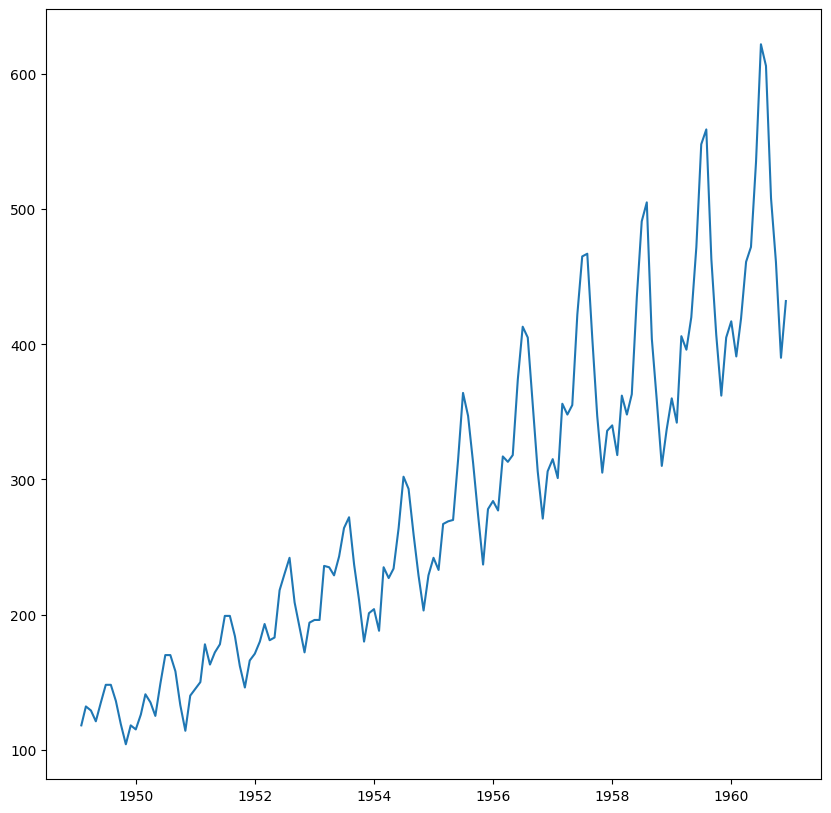

In [66]:
plt.plot(ap)

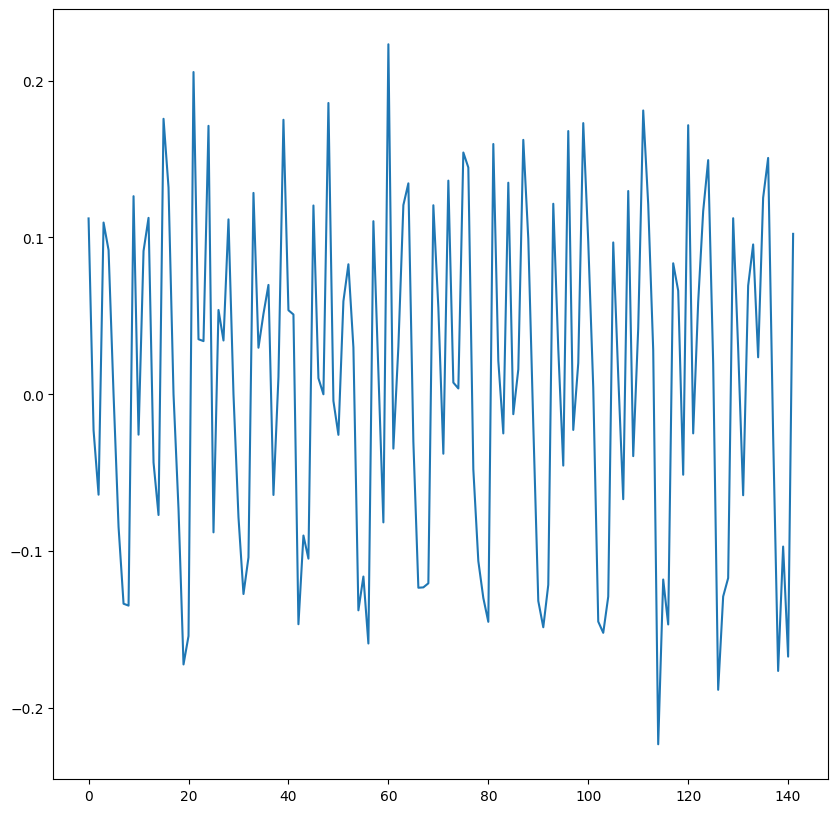

In [67]:
plt.plot(np.diff(np.log(ap.values[:, 0])))

In [68]:
ts = np.diff(np.log(ap.values[:, 0]))

In [69]:
vals = np.hstack([np.expand_dims(np.array(ts, dtype = np.float32), axis = 1) for _ in range(12)])

In [70]:
nrow = vals.shape[0]
for lag in range(1, vals.shape[1]):
    vals[:(nrow - lag),lag] = vals[lag:,lag]
    vals[(nrow - lag):, lag] = np.nan

In [71]:
vals = vals[:(vals.shape[0] - 12 + 1), :]

## Нам нужно найти способ генерировать объекты, которые кодируют позиционную информацию

### Сейчас сгенерируем собственные features

In [72]:
feats = np.zeros( (vals.shape[0], 6), dtype = np.float32)
for i in range(vals.shape[0]):
    feats[i, 0] = np.where(vals[i] == np.max(vals[i]))[0][0]
    feats[i, 1] = np.where(vals[i] == np.min(vals[i]))[0][0]
    feats[i, 2] = feats[i, 0] - feats[i, 1]
    feats[i, 3] = np.max(vals[i][-3:])
    feats[i, 4] = vals[i][-1] - vals[i][-2]
    feats[i, 5] = vals[i][-1] - vals[i][-3]

In [73]:
feats[0:3]

array([[ 9.        ,  8.        ,  1.        ,  0.12629372,  0.11710228,
        -0.03494394],
       [ 8.        ,  7.        ,  1.        ,  0.11247798,  0.0211282 ,
         0.13823047],
       [ 7.        ,  6.        ,  1.        ,  0.11247798, -0.1559631 ,
        -0.13483489]], dtype=float32)

### Сравним вид features

In [74]:
pd.DataFrame(feats[0:3])

,0,1,2,3,4,5
0,9.0,8.0,1.0,0.126294,0.117102,-0.034944
1,8.0,7.0,1.0,0.112478,0.021128,0.138230
2,7.0,6.0,1.0,0.112478,-0.155963,-0.134835


In [75]:
outcomes = vals[:, -1]

In [76]:
X_train, y_train = feats[:100, :], outcomes[:100]
X_test, y_test   = feats[100:, :], outcomes[100:]

In [77]:
model = xgb.XGBRegressor(n_estimators=20, max_depth=2,
                              random_state=21)
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.10371
[1]	validation_0-rmse:0.09751
[2]	validation_0-rmse:0.09451
[3]	validation_0-rmse:0.09097
[4]	validation_0-rmse:0.08793
[5]	validation_0-rmse:0.08134
[6]	validation_0-rmse:0.07893
[7]	validation_0-rmse:0.07472
[8]	validation_0-rmse:0.07306
[9]	validation_0-rmse:0.07019
[10]	validation_0-rmse:0.06908
[11]	validation_0-rmse:0.06766
[12]	validation_0-rmse:0.06698
[13]	validation_0-rmse:0.06589
[14]	validation_0-rmse:0.06484
[15]	validation_0-rmse:0.06394
[16]	validation_0-rmse:0.06364
[17]	validation_0-rmse:0.06269
[18]	validation_0-rmse:0.06215
[19]	validation_0-rmse:0.06185


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=21, ...)

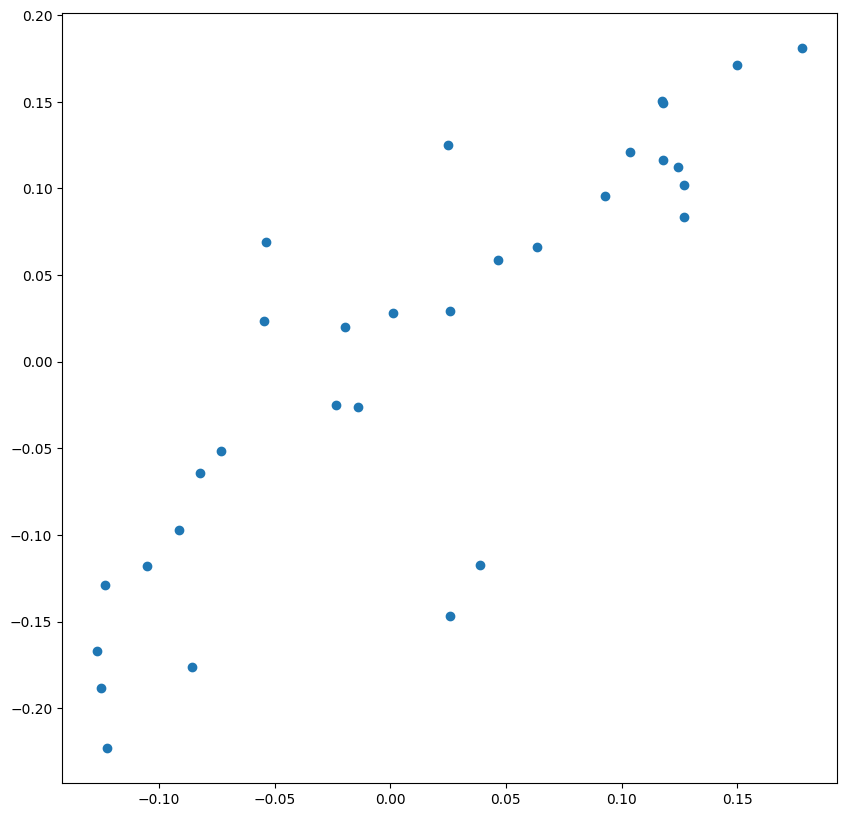

In [78]:
plt.scatter(model.predict(X_test), y_test)

In [79]:
print(pearsonr(model.predict(X_test), y_test))
print(spearmanr(model.predict(X_test), y_test))

PearsonRResult(statistic=0.8556282058125362, pvalue=8.6165414e-10)
SignificanceResult(statistic=0.8523896120071992, pvalue=1.1629013187748e-09)


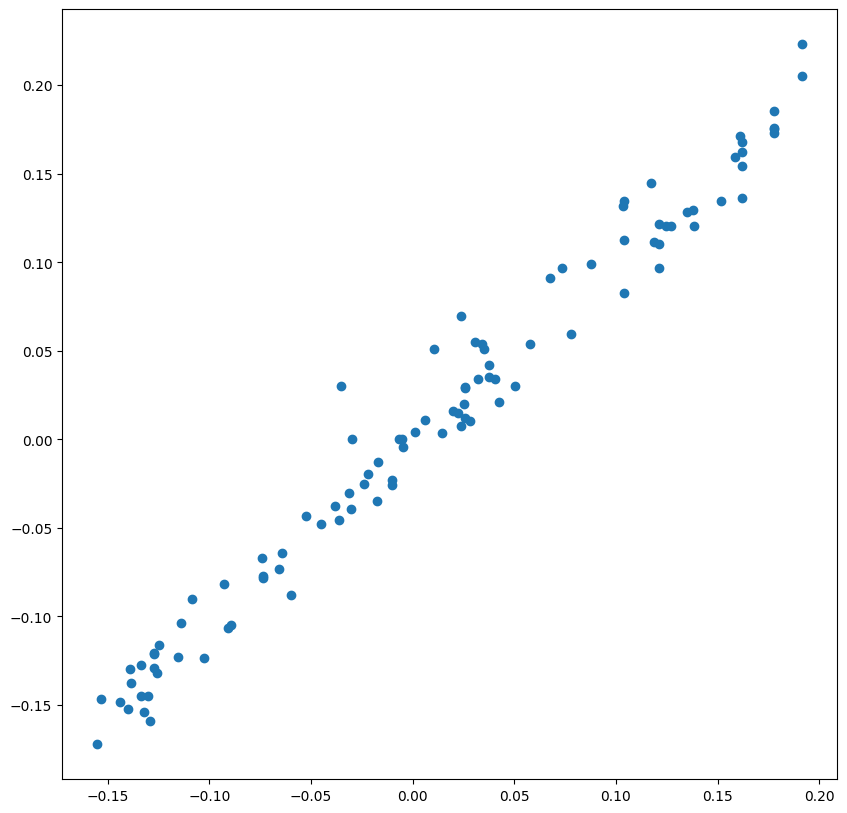

In [80]:
plt.scatter(model.predict(X_train), y_train)

In [81]:
print(pearsonr(model.predict(X_train), y_train))
print(spearmanr(model.predict(X_train), y_train))

PearsonRResult(statistic=0.9877637483409671, pvalue=0.0)
SignificanceResult(statistic=0.9830641776191977, pvalue=4.937378308943359e-74)


## Кластеризация

In [82]:
! pip install dtaidistance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from math import sqrt

from datetime import datetime
import pandas as pd
import numpy as np
import pdb


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import homogeneity_score, completeness_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import homogeneity_score

from dtaidistance import dtw

from collections import Counter

from scipy.stats import pearsonr

## В качестве исходных данных будем рассматривать подмножество набора FiftyWords.
Этот набор данных был создан авторами статьи о кластеризации рукописных слов в исторических документах) еще в 2003 году. В этой статье авторы предложили использовать своеобразные “профили слов” для масштабирования двумерного изображения рукописного слова в одномерную кривую, представленную одинаковым количеством измерений независимо от длины слова.

In [83]:
words = pd.read_csv('https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/50words_TEST.csv',
                   header = None)

In [84]:
words.rename(columns = {0:'word'}, inplace = True) 

In [85]:
words.head()

,word,1,2,3,4,5,6,7,8,9,...,261,262,263,264,265,266,267,268,269,270
0,4,-0.89094,-0.86099,-0.82438,-0.78214,-0.73573,-0.68691,-0.63754,-0.589370,-0.543420,...,-0.86309,-0.86791,-0.87271,-0.87846,-0.88592,-0.89619,-0.90783,-0.91942,-0.93018,-0.93939
1,12,-0.78346,-0.68562,-0.58409,-0.47946,-0.37398,-0.27008,-0.17225,-0.087463,-0.019191,...,-0.88318,-0.89189,-0.90290,-0.91427,-0.92668,-0.93966,-0.95244,-0.96623,-0.98050,-0.99178
2,13,-1.32560,-1.28430,-1.21970,-1.15670,-1.09980,-1.04960,-1.01550,-0.996720,-0.985040,...,-0.83499,-0.86204,-0.88559,-0.90454,-0.93353,-0.99135,-1.06910,-1.13680,-1.19800,-1.27000
3,23,-1.09370,-1.04200,-0.99840,-0.95997,-0.93997,-0.93764,-0.92649,-0.857090,-0.693320,...,-0.72810,-0.74512,-0.76376,-0.78068,-0.80593,-0.84350,-0.89531,-0.96052,-1.05090,-1.12830
4,4,-0.90138,-0.85228,-0.80196,-0.74932,-0.69298,-0.63316,-0.57038,-0.506920,-0.446040,...,-0.95452,-0.97322,-0.98984,-1.00520,-1.01880,-1.02960,-1.03700,-1.04110,-1.04180,-1.04030


Примеры представления разных слов приведены на рисунках.
Идея заключается в том, чтобы обозначить одинаковые слова одной и той же подписью, чтобы в дальнейшем сократить усилия по разметке документов.

### Классификация и регрессия
В предыдущих примерах рассмотрены принципы классификации временных рядов с использованием алгоритмов случайных лесов и градиентного бустинга. Не менее эффективно они применяются для прогнозирования временных рядов. Многие специалисты по статистике считают, что в прогнозировании данных машинное обучение позволяет добиться не намного больших, если не меньших, успехов, чем традиционный статистический подход в анализе временных рядов.
Тем не менее за последние несколько лет градиентный бустинг деревьев стал опорным камнем технологий прогнозирования, часто превосходя традиционные статистические модели особенно при обработке больших наборов данных — как в соревнованиях по прогнозированию, так и в промышленных приложениях. Тем не менее при его использовании приходится уделять много внимания настройке параметров моделей, а также подготовке признаков временных рядов.
Одно из неоспоримых преимуществ моделей градиентного бустинга заключается в способности автоматического отсеивания нерелевантных или зашумленных признаков и выделении наиболее важных из них. Однако одного только этого недостаточно для получения самых передовых по характеристикам моделей. Даже для, казалось бы, автоматического метода, такого как градиентный бустинг деревьев, выходные данные могут оказаться не намного лучшими по качеству входных данных На этом фоне самым важным способом улучшения модели по-прежнему будет предоставление качественных и хорошо протестированных признаков для входных данных.
Существует много вариантов улучшения текущей модели. В частности, можно обратиться к специальным функциям пакета XGBoost для определения степеней важности признаков. Это поможет разделить полезные и неиспользуемые признаки и впоследствии расширить набор данных, добавив первые к тем, которые были признаны полезными ранее. Кроме того, можно выполнить поиск по сетке  гиперпараметров, чтобы более точно настроить параметры модели. Наконец, всегда можно более тщательно изучить необработанные временные ряды размеченных данных, попытавшись распознать в них ошибочные данные, которые невозможно представить текущим набором признаков. Стоит задуматься о добавлении признаков, которые наилучшим образом описывают ошибочно распознанные данные, что приведет к дополнительному их уточнению.
### Кластеризация
Главная идея кластеризации состоит в отнесении точек данных с похожими характеристиками к разным группам, представляющим отдельные цели для анализа. Такой подход оказывается верным не только для наборов временных рядов, но и для любых других видов данных.
Как и в любом другом случае, я исхожу из предположения, что вы немного знакомы с соответствующими концепциями машинного обучения — хотя бы применимо к данным, не имеющим выраженной временной направленности. Если же вы не знакомы с кластеризацией, то для начала хотя бы кратко ознакомьтесь с ее основными принципами (https: //perma.cc/36EX-3QJU).
В анализе временных рядов кластеризация может применяться как для классификации, так и для прогнозирования. В первом случае алгоритмы кластеризации применяются для определения требуемого количества кластеров на этапе обучения. Затем эти кластеры используются для выделения типов временных рядов и отнесения целевых выборок к соответствующей группе.
При прогнозировании кластеризация задействуется в явном виде или проявляется в опосредованной форме — для определения метрик расстояний (подробнее о них вы узнаете далее). Существует несколько вариантов построения прогнозов на будущем горизонте й, основанных на кластеризации данных и связанных с ними методов. Помните, что в подобном случае наблюдается не полный временной ряд, а только его первые N шагов, по которым предсказываются значения на временном шаге N + h. Здесь также возможно несколько вариантов действий.
Один из них заключается в составлении прогноза по типичному поведению данных, характерному для рассматриваемого класса. Сначала на основе первых N временных шагов определяется кластер, к которому относится выборка временного ряда, а затем прогнозируется поведение по принадлежности к такому кластеру.
В частности, на этом этапе нужно отследить изменения в значениях временных рядов между временными шагами N и N + h. Обратите внимание, что первоначальная кластеризация на основе их первых N шагов выполняется для всех временных рядов, а не для всех частей временного ряда, чтобы избежать упреждения.
Еще один вариант — предсказать будущее поведение выборочного временного ряда по поведению его ближайшего соседа (или соседей) в выборочном пространстве. В этом сценарии находятся ближайшие соседи выборки временного ряда, для которых известна полная траектория, на основе показателей из первых N временных шагов, а затем усредняется поведение таких ближайших соседей в момент N + h, чтобы получить прогноз для текущей выборки.
В случае классификации и прогнозирования наиболее важным фактором выступает способ оценки сходства между временными рядами. Кластеризация может быть выполнена для различных расстояний, и способам их определения в задачах высокой размерности посвящено большое количество исследований. Например, каково расстояние между двумя соискателями? Каким будет правильное расстояние между двумя выборками показателей крови? Такие задачи давно изучаются в статическом анализе данных — нам предстоит разобраться в них в контексте анализа временных рядов.
В нашем распоряжении есть два больших класса метрик расстояния (схожести), применяемых в методах кластеризации по отношению к данным временных рядов.
Расстояние, основанное на признаках Создайте признаки для временных рядов и обработайте их как координаты, для которых необходимо рассчитать данные. Это не полностью решает проблему выбора метрики расстояния, но сводит ее к стандартной задаче определения расстояния в наборе статических данных.
Расстояние на основе необработанных данных временного ряда Найдите способ определения “близости” временных рядов, предпочтительно таким образом, чтобы учитывать разные временные масштабы, различное количество измерений и другие вероятные отличия в выборках временных рядов.
Далее мы будем применять оба способа определения метрики расстояния к набору данных временного ряда, в котором каждая выборка представляет проекцию рукописного слова из двумерного изображения в одномерный временной ряд.
### Генерация признаков из данных
Ранее мы обсудили способы создания и выбора признаков. Далее нам предстоит оценить расстояние между наборами данных временных рядов на основе сходства их признаков.
В идеальном сценарии, используя дерево для оценки важности признаков, из набора данных отсеиваются малозначимые и неинтересные временные ряды.
При этом такие признаки не применяются в методиках расчета расстояния, поскольку могут ошибочно указывать на различия между двумя временными рядами, в то время как самом деле они не свидетельствуют о сходстве целевых классов в задаче классификации или результатах прогнозирования.
Как и в случае с набором данных ЭЭГ, анализ данных стоит начать с изучения отдельных примеров классов и определения очевидных различий во временной структуре наборов данных временных рядов.
В качестве исходных данных будем рассматривать подмножество набора FiftyWords (https://oreil.ly/yadNp), доступного для загрузки из репозитория UEA and UCR Time Series Classification. Этот набор данных был создан авторами статьи о кластеризации рукописных слов в исторических документах (https://oreil.ly/01UJ8) еще в 2003 году. В этой статье авторы предложили использовать своеобразные “профили слов” для масштабирования двумерного изображения рукописного слова в одномерную кривую, представленную одинаковым количеством измерений независимо от длины слова. Набор данных в репозитории не совпадает с описанным в документе, но имеет схожую структурную организацию. Целью оригинальной работы было разработка метода унифицированного обозначения всех схожих или идентичных слов в документе, что позволяет в дальнейшем обозначить их цифровой подписью (подвиг, который в наши дни “элементарно” осуществляется нейронной сетью, прошедшей 20-летний путь постоянного усовершенствования).
Таким образом, в этом примере анализ данных основан на работе с профилями проекции слову в которых термин “проекция” указывает на преобразование изображения из двумерного вида в одномерный, и это очень важный этап, поскольку размерность данных имеет первостепенную важность в анализе временных рядов. Обратите внимание, что ось времени не содержит временных меток, а представляет последовательность написанных слов слева направо. Тем не менее структура таких данных полностью повторяет принятую для временных рядов (упорядоченные и равномерно распределенные значения), поэтому в дальнейшем они будут описываться терминами время и временной, хотя это и не совсем верно. В рассматриваемом сценарии это не имеет принципиального значения.
Примеры представления разных слов приведены на рисунке 8.4 (Обратите внимание, что информация о фактическом содержании каждого “слова” остается недоступной и не особенно актуальна при сборе всего исходного набора данных. Идея заключается в том, чтобы обозначить одинаковые слова одной и той же подписью, чтобы в дальнейшем сократить усилия по разметке документов.)
Рис. 8.4. Профили проекции трех разных слов (12,23 и 9) сильно различаются между собой. На них просматриваются признаки, по которым различаются слова: временное расположение (ось х) самого большого или второго по величине пика, количество локальных пиков, общий диапазон значений и средняя выпуклость кривых

Рассматривая полученные данные, и особенно анализируя очевидные закономерности, проявляющиеся при визуальном изучении графиков, так же, как в данных ЭЭГ, можно определиться с важными для дальнейшего анализа признаками, например, указывающими высоту и расположение пиков, а также с отдельными их характеристиками, в частности с крутизной и формой вершины.
Многие из таких признаков становятся более значимыми при распознавании изображений, чем временных рядов, и могут использоваться в качестве основы для генерации признаков в других задачах. Зачастую визуализация данных, выполняемая очень просто, может предоставить намного больше понятной и полезной информации, чем утомительное изучение длинных последовательностей значений временных рядов. Таким образом, определяясь с признаками, не пренебрегайте изучением графического представления данных. Один только этот факт указывает на сложность и важность операции генерации признаков в анализе временных рядов. В некоторых случаях различия в классах временных рядов проявляются достаточно сильно, но описать их в коде оказывается далеко не так просто, как хотелось бы. Или вдруг выясняется, что написание такого кода оказывается чрезвычайно затратным занятием.
В последнее десятилетие самым перспективным инструментом классификации изображений стало глубокое обучение. При наличии достаточного количества данных можно обучить классификатор глубокого обучения на изображениях наших графиков. Но на данный момент мы не будем акцентировать свое внимание на нем, а обсудим сложности более простых вариантов реализации. В частности, генерировать признаки, определяющие местоположение каждого пика, достаточно сложно, поскольку обнаружение пиков требует значительных программных и вычислительных ресурсов и больше сродни искусству.
Воспользуемся для визуальной оценки данных одномерной гистограммой, построенной либо для всех, либо только для отдельных примеров классов. Такой подход оказывается менее затратным в вычислительном плане при нахождении пиков или поиске других критериев, представляющих целевые формы, которые проявляются во временных рядах. В следующем примере на графике отображаются те же члены класса, которые были представлены на предыдущем графике, но теперь в сопровождении одномерных гистограмм (рис. 9.5).


Text(0.5, 0.98, 'Sample word projections and histograms of the projections')

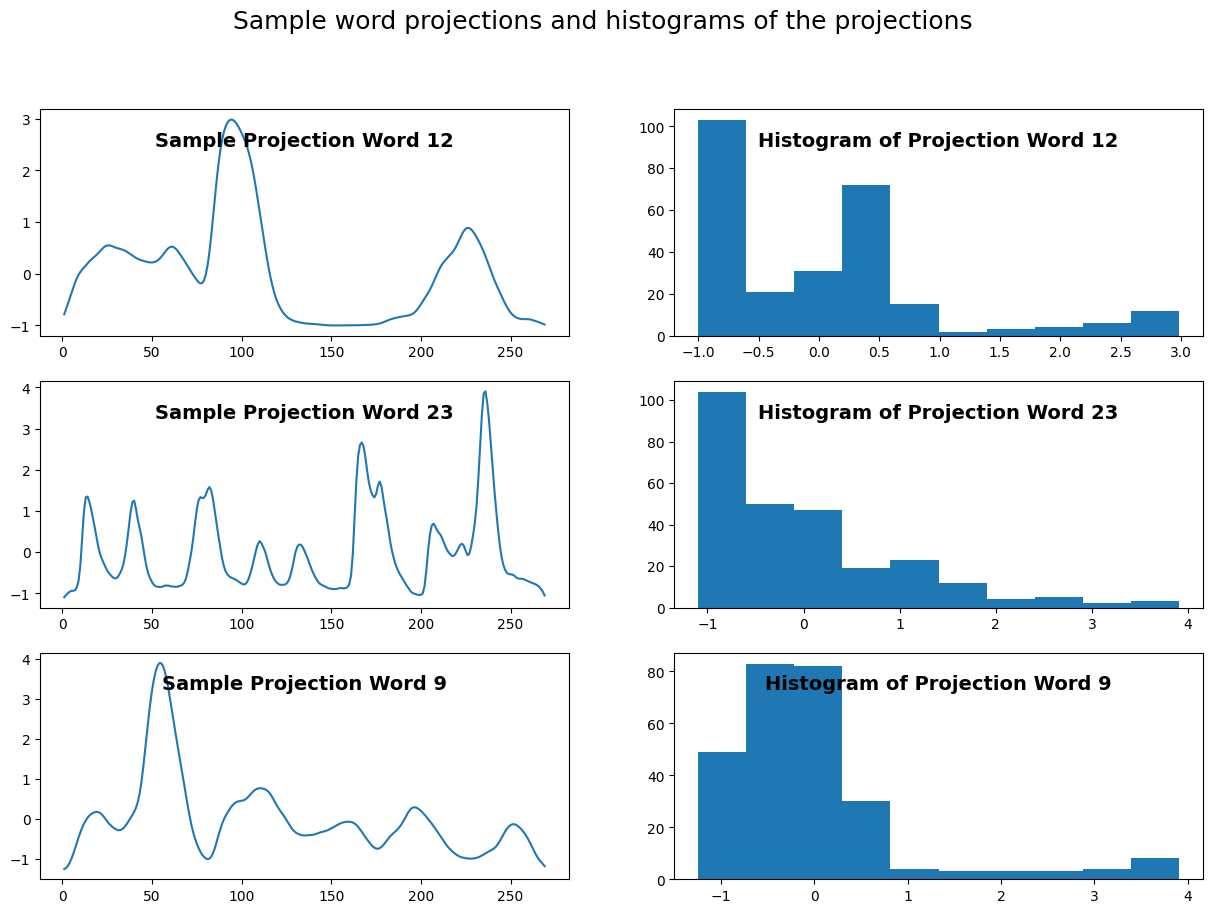

In [86]:
plt.subplot(3, 2, 1)
plt.plot(words.iloc[1, 1:-1])
plt.title("Sample Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 2)
plt.hist(words.iloc[1, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[1]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 3)
plt.plot(words.iloc[3, 1:-1])
plt.title("Sample Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 4)
plt.hist(words.iloc[3, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[3]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 5)
plt.plot(words.iloc[5, 1:-1])
plt.title("Sample Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.subplot(3, 2, 6)
plt.hist(words.iloc[5, 1:-1], 10)
plt.title("Histogram of Projection Word " + str(words.word[11]), fontweight = 'bold', y = 0.8, fontsize = 14)
plt.suptitle("Sample word projections and histograms of the projections", fontsize = 18)

Text(0, 0.5, 'Value')

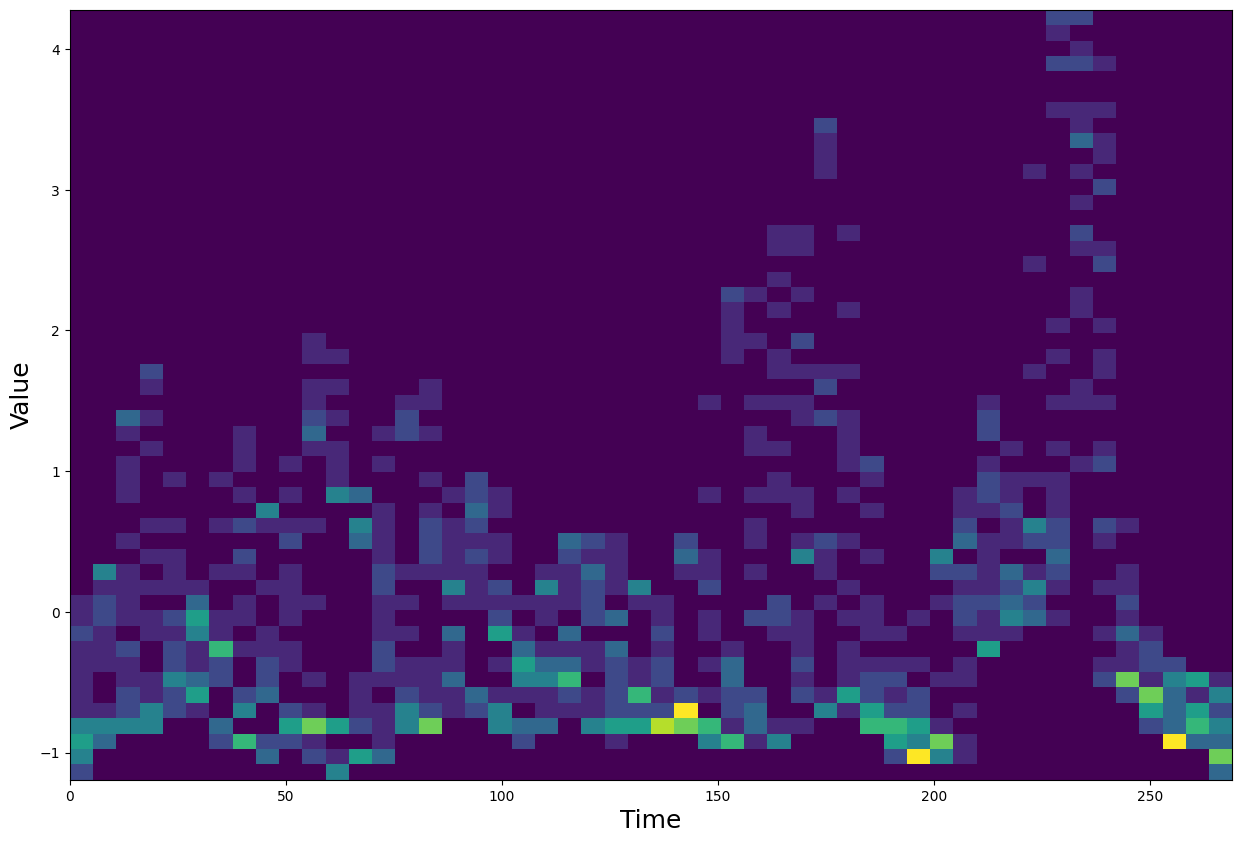

In [87]:
x = np.array([])
y = np.array([])

w = 23
selected_words = words[words.word == w]
selected_words.shape

for idx, row in selected_words.iterrows():
    y = np.hstack([y, row[1:271]])
    x = np.hstack([x, np.array(range(270))])
    
fig, ax = plt.subplots()
hist = ax.hist2d(x, y, bins = 50)
plt.xlabel("Time", fontsize = 18)
plt.ylabel("Value", fontsize = 18)

На рисунке 8.6 показана двумерная гистограмма для всех экземпляров слова 12 в наборе данных. Хотя отдельная кривая на рисунке показывает, что нужно сосредоточиться на поиске двух больших пиков, которые доминируют во временном ряду, гистограмма показывает, что, вероятнее всего, общим для большинства членов этого класса будет плоский участок между пиками, расположенными между временными шагами от 120 до 200.
Двумерную гистограмму также можно использовать для определения точки отсечения для максимального пика в заданном классе, который, по-видимому, находится между временными шагами 50 и 150, — всегда можно написать функцию, которая ответит на вопрос «достигается ли максимальное значение между точками 50 и 150?»
Рис. 8.7. Двумерная гистограмма одномерных проекций слова 23. На оси у откладываются значения на отдельных временных шагах, а ось х включает 270 временных шагов для каждой выборки временного ряда/проекции слова

Подобным образом построим еще одну двумерную гистограмму — на этот раз для слова 23, профиль которого характеризуется большим количеством маленьких выпуклостей (см. пример на рисунке 8.5), признаки которых также сложно поддаются программному вычислению (рисунок 8.7).
Неудивительно наблюдать сильно “размазанную” гистограмму для слова 23 (рисунок 8.7), учитывая тот факт, что даже в примере, представленном графиками на рисунке 8.5, проявляется достаточно много признаков, чтобы ожидать сильного размазывания для выборок с неточно совпадающими признаками. Тем не менее мы также видим, что максимальное значение этого класса относится к непересекающемуся диапазону временных шагов, в отличие от слова 12. В этом классе максимальное значение наблюдается после временного момента 150, что вполне проецируются в другой тип одномерных данных, по которым и определяются признаки). Таким образом, учитываются большие “мазки”, проявляющиеся на двумерных гистограммах и указывающих на наличие пиков, положение которых не отличается особой устойчивостью. Генерация второй характеристической формы для каждой проекции слова по гистограмме, а не исходной проекции слова, может оказаться более надежным способом. Гистограммы показывают, какие виды значений появляются во временном ряду, но не характеризуют их точное расположение, что крайне важно для нашего анализа, учитывая, что пики в проекциях не имеют стабильных временных мест расположения.
Сначала сгенерируем признаки для временного ряда длиной 270 временных точек. В нашем случае функция генерации признаков имеет сокращенное название, что сделано исключительно в целях улучшения читабельности кода.


In [88]:
from cesium.featurize import featurize_time_series as ft
word_vals = words.iloc[:, 1:271]
times = []
word_values = []
for idx, row in word_vals.iterrows():
    word_values.append(row.values)
    times.append(np.array ([i for i in range(row.values.shape[0])]))
features_to_use = ['amplitude','percent_close_to_median']
words_features = ft(times = times,values = word_values,errors = None,features_to_use = features_to_use,scheduler = None)

## Генерирование признаков по гистограммам

In [89]:
times = []
hist_values = []
for idx, row in words_features.iterrows():
    hist_values.append(np.histogram(row.values,bins=10,range=(-2.5, 5.0))[0] + .0001)
## обработка нулей вызывает
## дополнительные сложности
times.append(np.array([i for i in range(9)]))
features_to_use = ["amplitude","percent_close_to_median","skew"]
featurized_hists = ft(times = times,values = hist_values, errors = None, features_to_use = features_to_use,scheduler = None)
features = pd.concat([words_features .reset_index(drop=True),featurized_hists],axis=1)

## Временные метрики расстояния

При проведении кластерного анализа нужно определиться с метриками расстояния. Ориентируясь по признакам временных рядов, как показано выше, можно придерживаться самых разных стандартных методик, что характерно для кластерного анализа большинства перекрестных данных. Если вы не знакомы с принципами выбора метрик расстояния в подобных случаях, то обязательно обратитесь к соответствующим справочным руководствам (https://perma.сс/MHL9-2Y8A).
Сосредоточимся на задаче определения сходства временных рядов по метрикам расстояний. Одна из наиболее часто применяемых для таких целей метрик называется динамической деформацией времени (Dynamic Time Warping — DTW). Механизм DTW прекрасно подходит для кластеризации временных рядов, наиболее характерной особенностью которых является их общая форма, как в случае рассмотренной ранее визуализации проекций слов.
Название метода основано на методологии, которая базируется на временной “деформации” рядов данных для выравнивания вдоль временной оси с целью последующего сравнения форм. Концепцию динамического искажения времени лучше всего проиллюстрировать графически (рисунок 8.8). Временная ось (х) деформируется, т.е. расширяется или сжимается так, чтобы обеспечить наилучшее выравнивание точек между двумя кривыми (т.е. двумя временными рядами) для последующего сравнения их форм.
Рис. 8.8. Механизм динамической деформации времени. Каждая точка одного временного ряда сопоставляется с точкой альтернативного временного ряда. При этом однозначного сопоставления точек не требуется, что имеет несколько важных последствий: (1) временные ряды не обязательно должны иметь одинаковую длину или даже масштабы времени, главное — их форма; (2) время не всегда движется вперед в процессе подгонки и может протекать с разной скоростью в каждом временном ряду. Под движением времени подразумевается продвижение по кривой в направлении оси х

Заметьте, что при стандартной параметризации алгоритма фактические значения на временной оси одной кривой совершенно не совпадают со значениями другой временной оси. Никто не запрещает сравнивать временной ряд с наносекундным интервалом с другим временным рядом, данные которого масштабированы для нескольких тысячелетий (скорее всего, это будет далеко не самым разумным решением). Цель этого алгоритма — сравнить одни только визуальные формы без учета временной протяженности данных. Действительно, термин “время” в данном случае рассматривается в общем концептуальном понимании как направление равномерного распределения набора точек вдоль оси х, а не в строгом физическом проявлении.
Перечислим правила работы DTW.
• Каждая точка одного временного ряда должна соответствовать как минимум одной точке другого временного ряда.
• Первый и последний индексы каждого временного ряда должны сопоставляться с таковыми в другом временном ряду.
• Масштабирование данных должно выполняться так, чтобы обеспечить прямой (вперед), а не обратный порядок движения времени. Обратного хода времени можно избежать, если исключить сопоставление точек одного временного ряда с точками другого временного ряда, которые уже были пройдены на временной оси. Однако время не обязано должно двигаться вперед равномерно. Например, два последовательных временных шага в исходном ряду могут быть деформированы (сжаты во времени) таким образом, чтобы подогнать соответствующие значения к одному и тому же месту на оси х (см. первый излом верхней кривой/сплошной линии на рисунке).
Указанные правила предопределяют много разных способов временного выравнивания — выбранный нами вариант обеспечивает минимизацию расстояния между кривыми. Это расстояние, или функция стоимости, часто измеряется как сумма абсолютных разностей между совмещаемыми точками, где под абсолютной разностью подразумевают разницу между значениями точек.
Получив качественное представление о работе алгоритма DTW, давайте познакомимся с примером его программной реализации.


In [90]:
X = words.iloc[:, 1:271].values

In [91]:
X 

array([[-0.89094, -0.86099, -0.82438, ..., -0.91942, -0.93018, -0.93939],
       [-0.78346, -0.68562, -0.58409, ..., -0.96623, -0.9805 , -0.99178],
       [-1.3256 , -1.2843 , -1.2197 , ..., -1.1368 , -1.198  , -1.27   ],
       ...,
       [-1.1054 , -1.0898 , -1.0685 , ..., -0.99402, -1.0462 , -1.0878 ],
       [-1.5497 , -1.4997 , -1.4314 , ..., -1.5722 , -1.5654 , -1.5574 ],
       [-1.1383 , -1.1175 , -1.086  , ..., -0.99577, -1.0509 , -1.1041 ]])

In [92]:
def distDTW(ts1, ts2):
    DTW       = np.full((len(ts1) + 1, len(ts2) + 1), 0, dtype = np.float32)
    DTW[:, 0] = np.inf
    DTW[0, :] = np.inf
    DTW[0, 0] = 0

    for i in range(1, len(ts1) + 1):
        for j in range(1, len(ts2) + 1):
            idx1 = i - 1 
            idx2 = j - 1
            
            dist               = (ts1[idx1] - ts2[idx2])**2
            min_preceding_dist = min(DTW[i-1, j],DTW[i, j-1], DTW[i-1, j-1])

            DTW[i, j] = dist + min_preceding_dist

    return sqrt(DTW[len(ts1), len(ts2)])

In [93]:
from sklearn import preprocessing
feature_values = preprocessing.scale(features.values)
feature_values=np.nan_to_num(feature_values)

In [94]:
clustering = AgglomerativeClustering(n_clusters=50, linkage='ward')
clustering.fit(feature_values)
words['feature_label'] = clustering.labels_
words['feature_label']

0      47
1      19
2      14
3      24
4      36
       ..
450     5
451     4
452    39
453    45
454    22
Name: feature_label, Length: 455, dtype: int64

In [95]:
homogeneity_score(words.word, words.feature_label)

0.48392604683414675

### Расстояние или сходство
В источниках, посвященных поиску метрик расстояний между временными рядами, для описания упомянутых выше показателей часто применяется термин “сходство” В большинстве случаев эти термины рассматриваются как взаимозаменяемые — описывающие степень подобности временных рядов между собой. Тем не менее отдельные показатели могут показаться более подходящими, например расстояние Фреше, которое вычисляется в соответствующих единицах измерения (“футы” или “кг/доллар” или любых других единицах представления данных временного ряда). Остальные метрики расстояния, в частности корреляция, единицами измерения не снабжаются.
Иногда найти простое, но удачное решение помогает творческий подход. Всегда старайтесь как можно более точно оценить стоящие перед вами цели. Обратимся к публикации на сайте Stackoverflow (https://perma.cc/389W-68AH), в которой рассматривается задача поиска расстояния в конкретном приложении, а именно — при классификации временных рядов для дальнейшего сопоставления найденных классов с одним из трех центроидов, полученных в предыдущем кластерном анализе. Рассматриваются три следующих класса.
• Прямая линия.
• Пик в начале временного ряда, а затем — прямая линия.
• Пик в конце временного ряда, а затем — прямая линия. Автор публикации обнаружил, что несколько стандартных метрик расстояний, включая эвклидово и DTW, не подходят для решения задачи. Метрика DTW дает слишком грубую оценку, рассматривая любые временные ряды с пиком подобно временным рядам с пиками в конце и начале ряда (именно поэтому DTW нельзя считать панацеей, даже несмотря на высокую вычислительную затратность метода!).
Один из дотошных комментаторов предложил провести преобразование, которое повысило бы точность вычисления расстояний, а именно: сравнивать не исходные временные ряды, а временные ряды накопленных сумм. В результате как эвклидовы метрики расстояния, так и DTW приводят к правильному упорядочению — временной ряд с пиком в начале показал наименьшее расстояние для прототипа своего класса, но не равное расстоянию для прототипа с пиками в начале и конце временного ряда. Это напоминает подход, принятый в одном из более ранних примеров анализа, в котором для принятия модели ARIMA достаточно правильно преобразовать временной ряд, необработанные данные которого не удовлетворяют всем необходимым условиям.
Избегайте эвклидовых метрик расстояния при сравнении временных рядов Возможно, вы заметили, что эвклидово расстояние не упоминалось в приведенном выше обсуждении метрик подобия временных рядов. Эвклидово расстояние, как правило, плохо подходит для оценки сходства временных рядов. Чтобы понять, почему, сравним две синусоиды и прямую линию. Если синусоиды имеют одинаковый период, но разные фазы (смещены по оси времени х) или характеризуются разными амплитудами, то прямая линия будет иметь меньшее эвклидово расстояние до одной из синусоид, чем до другой. Это далеко не тот результат, который ожидалось получить, но он указывает на отдельные преимущества рассмотренных ранее метрик.
• Компенсация фазы — смещение по временной оси, которое не играет большой роли при сравнении.
• Распознавание сходства форм, а не сходства величин.
Ниже представлено простое упражнение обязательное для реализации вами.
Все же, остановив свой выбор на эвклидовом расстоянии, рассмотрите возможность использования его совместно с преобразованием Фурье. В этом случае уменьшение количества измерений осуществляется за счет ограничения частоты, что подходит для большинства данных временных рядов, поскольку высокие частоты оказывают слабое влияние на общую форму и динамику временного ряда. Другой вариант заключается в аппроксимации по методу символьной агрегации (SAX — Symbolic Aggregate Approximation), разработанному в 2007 году для уменьшения размерности временных рядов перед вычислением нижней границы эвклидова расстояния.
К сожалению, не существует универсального правила для выбора метрики расстояния. Вам придется проявить недюжинные старания, чтобы найти сбалансированное решение, учитывающее следующие факторы.
• Минимизация использования вычислительных ресурсов.
• Выбор расстояния, подчеркивающего признаки временного ряда, которые лучше всего соответствуют конечной цели.
• Метрика расстояния должна учитывать и подчеркивать сильные/слабые стороны аналитических методов, используемых для сравнения временных рядов. Например, кластеризация по методу /с-средних не предполагает попарного сравнения расстояний, но сводит к минимуму отклонения, так что в этом методе имеет смысл обратиться к эвклидовым метрикам.
Код кластеризации
Теперь, когда мы обсудили, как генерируются признаки для кластерного анализа и рассмотрели принципы измерения расстояние между временными рядами, выполним кластеризацию по выбранным признакам и согласно матрице попарных расстояний DTW с последующим сравнением результатов.
Иерархическая кластеризация нормализованных признаков
Вычислим признаки для слов, представленных в виде временных рядов, как для исходных записей, так и для их гистограмм. В дальнейшем такие признаки будут использоваться в совершенно разных масштабах, поэтому для применения к ним единой метрики расстояния их необходимо нормализовать, что является стандартной процедурой в задачах кластеризации, основанной на признаках.

Выберем алгоритм иерархической кластеризации и проведем обучение для 50 кластеров, поскольку в дальнейшем будем сопоставлять эти кластеры с 50 словами в исходном наборе данных.


### Иерархическая кластеризация с помощью матрицы расстояний DTW
Мы успешно завершили самую сложную часть метода прямой кластеризации временных рядов, основанного на вычислении матрицы попарных расстояний для DTW. Это очень затратная операция с точки зрения вычислительных ресурсов, поэтому полученные результаты лучше сохранить, чтобы иметь возможность вернуться к их анализу в случае любой необходимости.
Легко заметить, что кластеризация, выполняемая с помощью DTW, работает значительно лучше, чем кластеризация на основе признаков. Однако если вы запустите код вычисления расстояния DTW на своем компьютере, особенно на стандартном ноутбуке, то увидите, насколько больше времени отнимает выполнение алгоритма DTW по сравнению с вычислением признаков. Вполне вероятно, нужно заняться улучшением алгоритма кластеризации на основе признаков, поскольку кластеризация по расстоянию DTW не предполагает простых способов усовершенствования. Уточним варианты дальнейшего улучшения методик.
• Включить в рассмотрение признаки, а также расстояние DTW. Как с программной, так и с концептуальной точек зрения, совместное использование признаков и расстояния DTW является очень сложной для реализации задачей.
• Попробовать использовать другие метрики расстояний. Как обсуждалось ранее, правильный выбор расстояния зависит от исходных данных, поставленных целей и задач анализа. Таким образом, сначала нужно предельно точно определить цель анализа слов и только затем задуматься о том, действительно ли DTW представляет лучшую из доступных метрику расстояния для достижения поставленной цели.

